# Skyfield API

## Tests:

### Geocentric Coordinates:

In [ ]:
from skyfield.api import load

# Create a timescale and ask the current time.
ts = load.timescale()
t = ts.now()

# Load the JPL ephemeris DE421 (covers 1900-2050).
planets = load('de421.bsp')
earth, mars = planets['earth'], planets['mars']

# What's the position of Mars, viewed from Earth?
astrometric = earth.at(t).observe(mars)
ra, dec, distance = astrometric.radec()

print(ra)
print(dec)
print(distance)

### Topocentric Coordinates:

In [ ]:
from skyfield.api import N, W, wgs84

boston = earth + wgs84.latlon(42.3583 * N, 71.0636 * W)
astrometric = boston.at(t).observe(mars)
alt, az, d = astrometric.apparent().altaz()

print(alt)
print(az)

In [ ]:
from datetime import datetime, timezone 
from zoneinfo import ZoneInfo
dt = datetime(2000, 1, 2, 9, 30, 59, 0, tzinfo=ZoneInfo("America/New_York"))
t = ts.from_datetime(dt)
print(dt.strftime("%m/%d/%Y, %H:%M:%S.%f %Z"))
print(t)

In [ ]:
from skyfield.api import N, W, wgs84

boston = earth + wgs84.latlon(42.3583 * N, 71.0636 * W)
astrometric = boston.at(t).observe(mars)
alt, az, d = astrometric.apparent().altaz()

print(alt)
print(az)
print(d)

See [Adding Messier objects to a plot but they do not align with stars #634](https://github.com/skyfielders/python-skyfield/discussions/634)

## Sample Code:

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

from skyfield.api import Star, load
from skyfield.constants import GM_SUN_Pitjeva_2005_km3_s2 as GM_SUN
from skyfield.data import hipparcos, mpc, stellarium
from skyfield.projections import build_stereographic_projection

# The comet is plotted on several dates `t_comet`.  But the stars only
# need to be drawn once, so we take the middle comet date as the single
# time `t` we use for everything else.

ts = load.timescale()
t_comet = ts.utc(2020, 7, range(17, 27))
t = t_comet[len(t_comet) // 2]  # middle date

# An ephemeris from the JPL provides Sun and Earth positions.

eph = load('de421.bsp')
sun = eph['sun']
earth = eph['earth']

# The Minor Planet Center data file provides the comet orbit.

with load.open(mpc.COMET_URL) as f:
    comets = mpc.load_comets_dataframe(f)

comets = (comets.sort_values('reference')
          .groupby('designation', as_index=False).last()
          .set_index('designation', drop=False))

row = comets.loc['C/2020 F3 (NEOWISE)']
comet = sun + mpc.comet_orbit(row, ts, GM_SUN)

# The Hipparcos mission provides our star catalog.

with load.open(hipparcos.URL) as f:
    stars = hipparcos.load_dataframe(f)

# And the constellation outlines come from Stellarium.  We make a list
# of the stars at which each edge stars, and the star at which each edge
# ends.

url = ('https://raw.githubusercontent.com/Stellarium/stellarium/master'
       '/skycultures/modern_st/constellationship.fab')

with load.open(url) as f:
    constellations = stellarium.parse_constellations(f)

edges = [edge for name, edges in constellations for edge in edges]
edges_star1 = [star1 for star1, star2 in edges]
edges_star2 = [star2 for star1, star2 in edges]

# We will center the chart on the comet's middle position.

center = earth.at(t).observe(comet)
projection = build_stereographic_projection(center)
field_of_view_degrees = 75.0
limiting_magnitude = 7.0

# Now that we have constructed our projection, compute the x and y
# coordinates that each star and the comet will have on the plot.

star_positions = earth.at(t).observe(Star.from_dataframe(stars))
stars['x'], stars['y'] = projection(star_positions)

comet_x, comet_y = projection(earth.at(t_comet).observe(comet))

# Create a True/False mask marking the stars bright enough to be
# included in our plot.  And go ahead and compute how large their
# markers will be on the plot.

bright_stars = (stars.magnitude <= limiting_magnitude)
magnitude = stars['magnitude'][bright_stars]
marker_size = (0.5 + limiting_magnitude - magnitude) ** 2.0

# The constellation lines will each begin at the x,y of one star and end
# at the x,y of another.  We have to "rollaxis" the resulting coordinate
# array into the shape that matplotlib expects.

xy1 = stars[['x', 'y']].loc[edges_star1].values
xy2 = stars[['x', 'y']].loc[edges_star2].values
lines_xy = np.rollaxis(np.array([xy1, xy2]), 1)

# Time to build the figure!

fig, ax = plt.subplots(figsize=[9, 9])

# Draw the constellation lines.

ax.add_collection(LineCollection(lines_xy, lw=2.0, colors='#00f2'))

# Draw the stars.

ax.scatter(stars['x'][bright_stars], stars['y'][bright_stars],
           s=marker_size, color='k')

# Draw the comet positions, and label them with dates.

comet_color = '#f00'
offset = 0.002

ax.plot(comet_x, comet_y, '+', c=comet_color, zorder=3)

for xi, yi, tstr in zip(comet_x, comet_y, t_comet.utc_strftime('%m/%d')):
    tstr = tstr.lstrip('0')
    text = ax.text(xi + offset, yi - offset, tstr, color=comet_color,
                   ha='left', va='top', fontsize=9, weight='bold', zorder=-1)
    text.set_alpha(0.5)

# Finally, title the plot and set some final parameters.

angle = np.pi - field_of_view_degrees / 360.0 * np.pi
limit = np.sin(angle) / (1.0 - np.cos(angle))

ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_aspect(1.0)
ax.set_title('Comet NEOWISE {} through {}'.format(
    t_comet[0].utc_strftime('%Y %B %d'),
    t_comet[-1].utc_strftime('%Y %B %d'),
))

# Show the plot
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from skyfield import almanac
from skyfield.api import load, wgs84
from skyfield.magnitudelib import planetary_magnitude

MONTH_NAMES = '0 Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec'.split()

# Figure out the times of sunset over our range of dates.

eph = load('de421.bsp')
earth, sun, venus = eph['earth'], eph['sun'], eph['venus']
observer = wgs84.latlon(+40.0, 0.0)

ts = load.timescale()
start, end = ts.utc(2021, 3, 7), ts.utc(2022, 2, 7)

f = almanac.sunrise_sunset(eph, observer)
t, y = almanac.find_discrete(start, end, f)
sunsets = (y == 0)
t = t[sunsets]

# For each moment of sunset, ask Skyfield for the month number, the day
# number, and for Venus’s altitude, azimuth, and magnitude.

year, month, day, hour, minute, second = t.utc
month = month.astype(int)
day = day.astype(int)

apparent = (earth + observer).at(t).observe(venus).apparent()
alt, az, distance = apparent.altaz()
x, y = az.degrees, alt.degrees
m = planetary_magnitude(apparent)

# Convert magnitude to marker size, remembering that smaller magnitude
# numbers mean a brighter Venus (and thus a larger marker).

maxmag = max(m)
minmag = min(m)
size = 40 - 30 * (m - minmag) / (maxmag - minmag)

# Start with a smooth curve tracing Venus's motion.

fig, ax = plt.subplots(figsize=[9, 3])
ax.plot(x, y, c='#fff6', zorder=1)

# Next, put a circle representing Venus on the 1st of the month and on
# every fifth day after that.  (Except for the 30th, which would sit too
# close to the 1st of the following month.)

fives = (day % 5 == 1) & (day < 30)
ax.scatter(x[fives], y[fives], size[fives], 'white',
           edgecolor='black', linewidth=0.25, zorder=2)

# Put day and month labels off to the sides of the curve.

offset_x, offset_y = 10, 8

for i in np.flatnonzero(fives):
    if i == 0:
        continue  # We can’t compute dx/dy with no previous point.

    # Build a unit vector pointing in the direction Venus is traveling.

    day_i = day[i]
    xi = x[i]
    yi = y[i]
    dx = xi - x[i-1]
    dy = yi - y[i-1]
    length = np.sqrt(dx*dx + dy*dy)
    dx /= length
    dy /= length

    # Offset the text at a right angle to the direction of travel.

    side = 'right' if (year[i], month[i]) < (2021, 10) else 'left'
    if side == 'left':
        xytext = - offset_x*dy, offset_y*dx
    else:
        xytext = offset_x*dy, - offset_y*dx

    # Label the dates 1, 11, and 21.

    if day_i in (1, 11, 21):
        ax.annotate(day_i, (xi, yi), c='white', ha='center', va='center',
                    textcoords='offset points', xytext=xytext, size=8)

    # On the 15th of each month, put the month name.

    if day_i == 16:
        name = MONTH_NAMES[month[i]]
        ax.annotate(name, (xi, yi), c='white', ha='center', va='center',
                    textcoords='offset points', xytext=2.2 * np.array(xytext))

# Finally, some decorations.

points = 'N NE E SE S SW W NW'.split()
for i, name in enumerate(points):
    xy = 45 * i, 1
    ax.annotate(name, xy, c='white', ha='center', size=12, weight='bold')

ax.set(
    aspect=1.0,
    title='Venus at sunset for 40°N latitude, April 2021 – January 2022',
    xlabel='Azimuth (°)',
    ylabel='Altitude (°)',
    xlim=(195, 300),
    ylim=(0, max(y) + 10.0),
    xticks=np.arange(210, 300, 15),
)

sky = LinearSegmentedColormap.from_list('sky', ['black', 'blue'])
extent = ax.get_xlim() + ax.get_ylim()
ax.imshow([[0,0], [1,1]], cmap=sky, interpolation='bicubic', extent=extent)

fig.savefig('venus_evening_chart.png')

## Polar coordinates:

Use Matplotlib [Polar Coordinates](https://matplotlib.org/stable/gallery/pie_and_polar_charts/polar_demo.html).

In [32]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

from datetime import datetime, timezone 
from zoneinfo import ZoneInfo

from skyfield.api import N, W, wgs84
from skyfield.api import Star, load
from skyfield.constants import GM_SUN_Pitjeva_2005_km3_s2 as GM_SUN
from skyfield.data import hipparcos, mpc, stellarium
from skyfield.projections import build_stereographic_projection

In [34]:
tzinfo=ZoneInfo("America/New_York")
dt = datetime(1983, 6, 10, 23, 0, 0, 0, tzinfo=tzinfo)
# dt = datetime(1980, 5, 30, 23, 0, 0, 0, tzinfo=tzinfo)
print(dt)
#
ts = load.timescale()
observe_time = ts.from_datetime(dt)

# An ephemeris from the JPL provides Sun and Earth positions.
eph = load('de421.bsp')
sun = eph['sun']
earth = eph['earth']
observe_location = earth + wgs84.latlon(28.6 * N, 81.35 * W ) 
# observe_location = earth + wgs84.latlon(40.8682 * N, 73.4257 * W ) 
print(observe_location)

1980-05-30 23:00:00-04:00
Sum of 3 vectors:
 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 3 EARTH BARYCENTER
 'de421.bsp' segment 3 EARTH BARYCENTER -> 399 EARTH
 Geodetic 399 EARTH -> WGS84 latitude +40.8682 N longitude -73.4257 E elevation 0.0 m


In [35]:
# The Minor Planet Center data file provides the comet orbit.
with load.open(mpc.COMET_URL) as f:
    comets = mpc.load_comets_dataframe(f)
comets = (comets.sort_values('reference')
          .groupby('designation', as_index=False).last()
          .set_index('designation', drop=False))

row = comets.loc['C/2020 F3 (NEOWISE)']
comet = sun + mpc.comet_orbit(row, ts, GM_SUN)

# The Hipparcos mission provides our star catalog.
with load.open(hipparcos.URL) as f:
    stars = hipparcos.load_dataframe(f)

# And the constellation outlines come from Stellarium.  We make a list
# of the stars at which each edge stars, and the star at which each edge
# ends.
url = ('https://raw.githubusercontent.com/Stellarium/stellarium/master'
       '/skycultures/modern_st/constellationship.fab')

# Constellations:
with load.open(url) as f:
    constellations = stellarium.parse_constellations(f)

edges = [edge for name, edges in constellations for edge in edges]
names = [name for name, edges in constellations for edge in edges]
print(len(names), len(set(names)))

848 88


In [36]:
print("Constellations: ", set(names))

constellation_names = {
    "Ori": "Orion",
    "And": "Andromeda",
    "Cas": "Cassiopeia",
    "Per": "Perseus",
    "Her": "Hercules",
    "UMi": "Ursa Major",
    "UMa": "Ursa Minor",
    "CMa": "Canis Major",
    "CMi": "Canis Minor",
    "Aur": "Auriga",
    "Dra": "Draco",
    "Cyg": "Cygnus",
    "Leo": "Leo",
    "Aqr": "Aquarius",
    "Gem": "Gemini",
    "Ari": "Aries",
    "Tau": "Taurus",
    "Cnc": "Cancer",
    "Sco": "Scorpio",
    "Lib": "Libra",
    "Vir": "Virgo",
    "Sgr": "Sagittarius",
    "Boo": "Bootis",
    "Oph": "Ophiuchus",
    "Ser": "Serpens",
    "CrB": "Corona Borealis",
    "Com": "Coma Berenices",
    "CVn": "Canes Venatici",
}

print(set(constellation_names.keys()) - set(names))

Constellations:  {'Ser', 'Vel', 'Tel', 'And', 'Hor', 'CVn', 'Ari', 'Nor', 'Aqr', 'PsA', 'Per', 'Cru', 'Tri', 'CrA', 'Lac', 'Peg', 'Ant', 'Cep', 'Tuc', 'Cas', 'Cam', 'Sex', 'Pyx', 'Lup', 'Cnc', 'Lib', 'Oct', 'Ori', 'Psc', 'Vir', 'Gru', 'Cap', 'Cir', 'Leo', 'Eri', 'Boo', 'Cae', 'Mon', 'Lep', 'Mic', 'Aql', 'Scl', 'Del', 'Ret', 'Lyn', 'For', 'CMa', 'UMa', 'Hyi', 'LMi', 'Car', 'Aps', 'Phe', 'Men', 'Tau', 'Pic', 'Pup', 'UMi', 'Oph', 'Ind', 'Vol', 'Sct', 'CMi', 'Cha', 'CrB', 'Crv', 'Hya', 'Sco', 'Cyg', 'Cen', 'Equ', 'Dra', 'Dor', 'Ara', 'Pav', 'Sge', 'Crt', 'Aur', 'Com', 'Her', 'Gem', 'Col', 'Cet', 'Lyr', 'Mus', 'TrA', 'Vul', 'Sgr'}
set()


In [37]:
planets = load('de421.bsp')
print(planets.names())

solar_system_object_names = [
    'MERCURY_BARYCENTER', 
    'VENUS_BARYCENTER', 
    # 'EARTH_BARYCENTER', 
    'MARS_BARYCENTER', 
    'JUPITER_BARYCENTER', 
    'SATURN_BARYCENTER',
    'URANUS_BARYCENTER',
    'NEPTUNE_BARYCENTER',
    'moon',
    # 'sun'
]

{0: ['SOLAR_SYSTEM_BARYCENTER', 'SSB', 'SOLAR SYSTEM BARYCENTER'], 1: ['MERCURY_BARYCENTER', 'MERCURY BARYCENTER'], 2: ['VENUS_BARYCENTER', 'VENUS BARYCENTER'], 3: ['EARTH_BARYCENTER', 'EMB', 'EARTH MOON BARYCENTER', 'EARTH-MOON BARYCENTER', 'EARTH BARYCENTER'], 4: ['MARS_BARYCENTER', 'MARS BARYCENTER'], 5: ['JUPITER_BARYCENTER', 'JUPITER BARYCENTER'], 6: ['SATURN_BARYCENTER', 'SATURN BARYCENTER'], 7: ['URANUS_BARYCENTER', 'URANUS BARYCENTER'], 8: ['NEPTUNE_BARYCENTER', 'NEPTUNE BARYCENTER'], 9: ['PLUTO_BARYCENTER', 'PLUTO BARYCENTER'], 10: ['SUN'], 199: ['MERCURY'], 299: ['VENUS'], 399: ['EARTH'], 301: ['MOON'], 499: ['MARS']}


In [38]:
# Filter constellation edges:
filtered_names_and_edges = list(filter(lambda x: x[1] in constellation_names, zip(edges, names)))
names = [x[1] for x in filtered_names_and_edges]
edges = [x[0] for x in filtered_names_and_edges]
print(len(names), len(set(names)))
print(len(edges))

edges_star1 = [star1 for star1, star2 in edges]
edges_star2 = [star2 for star1, star2 in edges]

def _polar_coords(row):
    coords = observe_location.at(observe_time).observe(Star.from_dataframe(row)).apparent().altaz()
    return (coords[1].radians, np.cos(coords[0].radians))

coords_1 = np.array(stars.loc[edges_star1].apply(_polar_coords, axis=1).tolist())
coords_2 = np.array(stars.loc[edges_star2].apply(_polar_coords, axis=1).tolist())
lines_rtheta = np.rollaxis(np.stack([coords_1, coords_2]), 1)

# We will center the chart on the comet's middle position.

center = observe_location.at(observe_time).observe(comet)
projection = build_stereographic_projection(center)

field_of_view_degrees = 180.0
limiting_magnitude = 6.0

print(len(stars.index))
stars = stars[stars.magnitude <= limiting_magnitude]
print(len(stars.index))

# Now that we have constructed our projection, compute the x and y
# coordinates that each star and the comet will have on the plot.
star_positions = observe_location.at(observe_time).observe(Star.from_dataframe(stars))
# stars['x'], stars['y'] = projection(star_positions)
stars["coord"] = stars.apply(
    lambda x: tuple(p.radians for p in observe_location.at(observe_time).observe(Star.from_dataframe(x)).apparent().altaz()[:2]),
    axis=1
)
stars["alt"] = stars["coord"].apply(lambda x: x[0])
stars["az"] = stars["coord"].apply(lambda x: x[1])

# Planets:
solar_system_object_coords = []
for name in solar_system_object_names:
    coords = observe_location.at(observe_time).observe(planets[name]).apparent().altaz()
    solar_system_object_coords.append([coords[1].radians, np.cos(coords[0].radians)])
solar_system_object_coords = np.array(solar_system_object_coords)

bright_stars = (stars.magnitude <= limiting_magnitude)
magnitude = stars['magnitude'][bright_stars]
marker_size = (0.5 + limiting_magnitude - magnitude) ** 2.0

# The constellation lines will each begin at the x,y of one star and end
# at the x,y of another.  We have to "rollaxis" the resulting coordinate
# array into the shape that matplotlib expects.

# xy1 = stars[['x', 'y']].loc[edges_star1].values
# xy2 = stars[['x', 'y']].loc[edges_star2].values
# lines_xy = np.rollaxis(np.array([xy1, xy2]), 1)

398 28
398
118218
5044


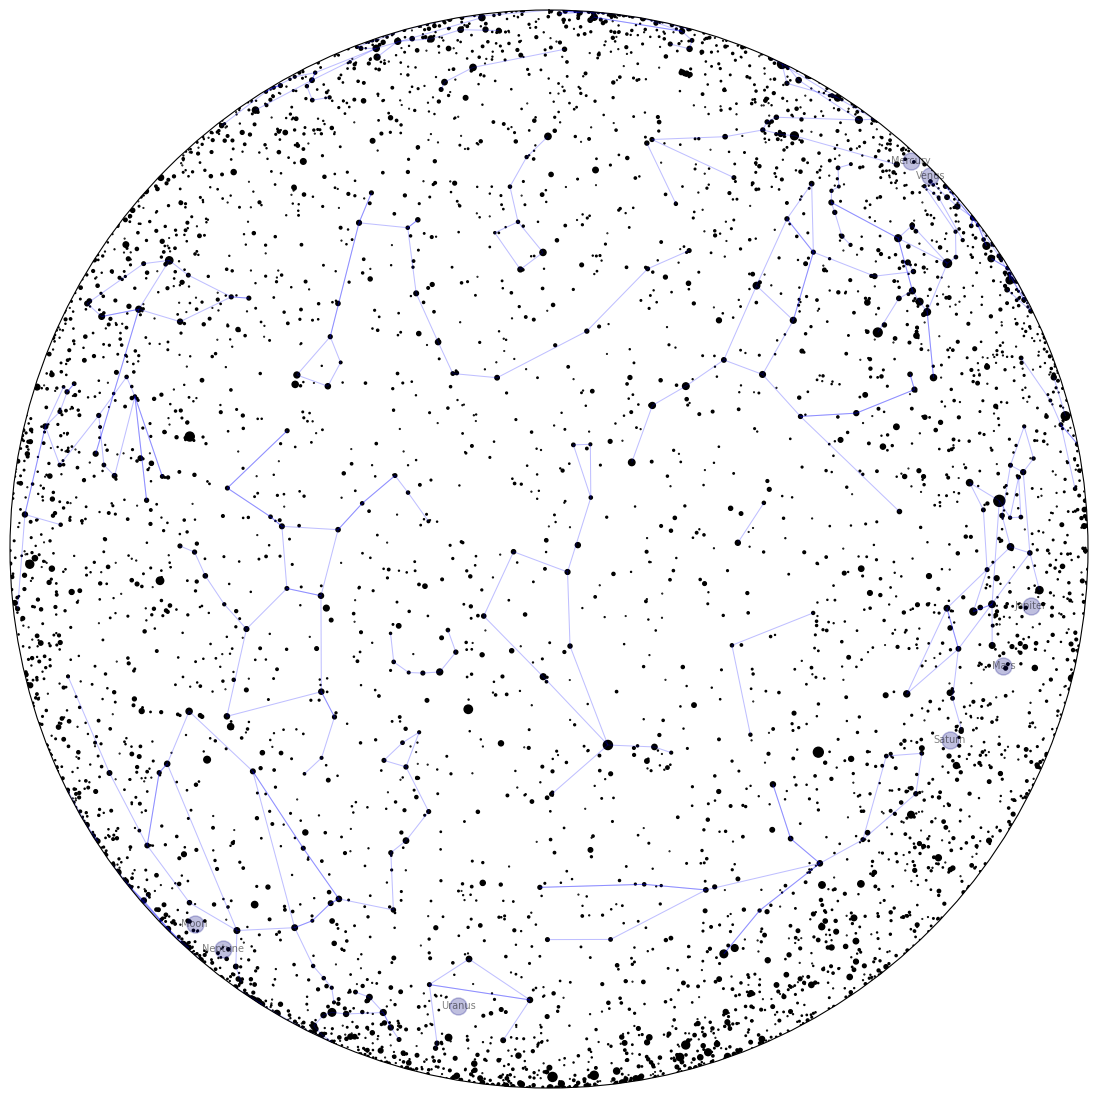

In [39]:
# fig, ax = plt.subplots(figsize=[9, 9])
fig, ax = plt.subplots(figsize=[14, 14], subplot_kw={'projection': 'polar'})


# ax.add_collection(LineCollection(lines_xy, lw=2.0, colors='#00f2'))
line_collection = LineCollection(lines_rtheta, lw=0.75, ls="-", colors='#00f2', alpha=0.25)
ax.add_collection(line_collection)

# Draw the stars.

# ax.scatter(stars['x'][bright_stars], stars['y'][bright_stars],
#            s=marker_size, color='k')
ax.scatter(
    stars['az'][bright_stars].values, 
    np.cos(stars['alt'][bright_stars].values), 
    s=marker_size, color='k')

ax.scatter(
    solar_system_object_coords[:, 0], 
    solar_system_object_coords[:, 1], 
    s=150.0, marker="o", edgecolor=None, color='navy', alpha=0.25)


for idx in range(len(solar_system_object_names)):
    ax.text(
        solar_system_object_coords[idx, 0], 
        solar_system_object_coords[idx, 1], 
        solar_system_object_names[idx].split("_")[0].lower().capitalize(),
        fontsize=7, ha="center", va="center", color='black', alpha=0.5
    )

# Draw the comet positions, and label them with dates.

comet_color = '#f00'
offset = 0.002

# ax.plot(comet_x, comet_y, '+', c=comet_color, zorder=3)

# for xi, yi, tstr in zip(comet_x, comet_y, t_comet.utc_strftime('%m/%d')):
#     tstr = tstr.lstrip('0')
#     text = ax.text(xi + offset, yi - offset, tstr, color=comet_color,
#                    ha='left', va='top', fontsize=9, weight='bold', zorder=-1)
#     text.set_alpha(0.5)

# # Finally, title the plot and set some final parameters.

# angle = np.pi - field_of_view_degrees / 360.0 * np.pi
# limit = np.sin(angle) / (1.0 - np.cos(angle))

ax.set_theta_zero_location("N")
ax.set_theta_direction("counterclockwise")

# ax.set_xlim(-limit, limit)
# ax.set_ylim(-limit, limit)
ax.set_rlim(0.0, 1.0)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
# ax.set_aspect(1.0)
# ax.set_title('Comet NEOWISE {} through {}'.format(
#     t_comet[0].utc_strftime('%Y %B %d'),
#     t_comet[-1].utc_strftime('%Y %B %d'),
# ))

# Show the plot
# plt.show()

# fig.savefig('053019802300.pdf')
fig.savefig('061019832300.pdf')

## Bug:

There is a bug in the way this thing works...

In [ ]:
observe_location.at(observe_time).observe(Star.from_dataframe(stars.iloc[0])).apparent().altaz()

In [ ]:
observe_location.at(observe_time).observe(Star.from_dataframe(stars.iloc[0:10])).apparent().altaz()